In [1]:
import os 
import cv2
import math
import pickle
import random
import numpy as np
import pandas as pd
from typing import Any
from pathlib import Path
from threading import Thread
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# get smoky-mountain-data-comp folder
HOME_DIR = str(Path().cwd().parent.parent)

# get the folder where to store data
DATA_FOLDER = "seg_from_contour"

# load the spreadsheet into the kernel
SHEET_DATA = pd.read_excel(f"{HOME_DIR}/step1/data.xlsx")
SHEET_DATA.head()

,filename,treatment,block,row,position,genotype
0,EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg,D,1.0,8.0,32.0,BESC-34
1,5AF900F9-D701-4994-95AC-2352420BF18F.jpg,C,1.0,10.0,12.0,"**BESC-417_LM**,core"
2,F7D01515-92CA-4AF5-9BD9-3A4CD99EDF42.jpg,C,2.0,3.0,40.0,BESC-468
3,9117861B-2D2B-4EA8-94B1-D0A862914398.jpg,C,2.0,6.0,54.0,BESC-28_LM
4,D1B282CF-2A10-4458-9E3A-FE08E065A3D6.jpg,C,1.0,24.0,22.0,"**LILD-26-5_LM**,core"


#### Function Declarations (copied from other notebook - run and hide this cell)

In [3]:
cv2.Contour = np.ndarray
cv2.BinaryImage = np.ndarray
cv2.Image = np.ndarray

# shows an image on ipynb
def imshow(img: np.ndarray) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# easy access grayscale function
def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# get a random filename from within the sheet
def get_random_filename() -> str:
    return SHEET_DATA['filename'][random.randint(0, len(SHEET_DATA)-1)]

def patchify(img: cv2.BinaryImage, n: int, iters: int) -> Any:
    assert n % 2, "Side length must be odd"
    """ Outputs a square of points around the center (0, 0) with corners removed. """
    new_img = img.copy()
    for _ in range(iters):
        diff = n // 2
        kernel = np.ones((n, n), dtype=np.uint8)
        for y in range(-diff, diff+1):
            for x in range(-diff, diff+1):
                if abs(y) + abs(x) > diff + 1:
                    kernel[y+diff][x+diff] = 0
        new_img = cv2.dilate(new_img, kernel)
    return new_img

# get contours that are optimized by the area - to - boudning rect metric, with large contours favored
def get_optimized_contours(contours: list[cv2.Contour], n: int = 1) -> list[cv2.Contour]:
    """ minimize the area of the rectangle and maximize contour area """
    adjusted_contours = []
    for contour in contours:
        _, _, w, h = cv2.boundingRect(contour)
        adjusted_contours.append([contour, cv2.contourArea(contour)**1.5/(w*h)])
    return [x[0] for x in sorted(adjusted_contours, key=lambda x: x[1], reverse=True)[:n]]

def filter_contours(contours: list[cv2.Contour], mask: cv2.BinaryImage) -> list[cv2.Contour]:
    l1, l2 = mask.shape[:2]
    contours = [i[0] for i in filter(
        lambda b: l1 // 16 < b[1][1] and l2 // 16 < b[1][0],
        [(cnt, cv2.boundingRect(cnt)[2:]) for cnt in contours]
    )]
    green_colored_contours = []
    for contour in contours: 
        mask_inside_contour = np.zeros_like(mask, np.uint8)
        mask_inside_contour = cv2.drawContours(mask_inside_contour, [contour], -1, 255, -1)
        mean = cv2.mean(mask, mask=mask_inside_contour)
        if mean[0] >= 100:
            green_colored_contours.append(contour)
    contours = get_optimized_contours(green_colored_contours, 15)
    return contours

def get_leaf_contours(img: cv2.Image) -> list[cv2.Contour]:

    # generate a mask for the image (colors we are interested in)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, (20, 50, 50), (80, 255, 255))
    masked = cv2.bitwise_and(img, img, mask=mask)

    # find the edges using the Canny algorithm
    img_blur = cv2.GaussianBlur(masked, (23, 23), sigmaX=0, sigmaY=0) 
    edges = cv2.Canny(img_blur, threshold1=20, threshold2=40)
    dilated = cv2.bitwise_not(patchify(edges, 13, iters=2))

    # find the contours in the resulting image to determine which ones are leaves
    contours = filter_contours(cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0], mask)

    return contours 

# display filename and image, and get image going to filename
def get_image(filename: str = None, show: bool = True):
    if filename is None:
        filename = get_random_filename()
    img = cv2.imread(f"{HOME_DIR}/dataset/{filename}")
    if show:
        print(filename)
        imshow(img)
    return img

# draw the contours onto the image
def draw_contours(contours: list[cv2.Contour], img: cv2.Image, mode: str = "random") -> cv2.Image:
    """ Draw contours onto an image with random colors """
    draw_img = img.copy()
    for contour in contours:
        if mode == "random":
            color = tuple(random.randint(150, 255) for _ in range(3))
        elif mode == "red": 
            color = (0, 0, 255)
        elif mode == "blue":
            color = (255, 0, 0)
        elif mode == "green":
            color = (0, 255, 0)
        else:
            raise Exception("Invalid color mode.")
        draw_img = cv2.drawContours(draw_img, [contour], -1, color, 5)
    return draw_img

##### Feature extraction from leaves

F7A23842-C5E1-42ED-9E09-DF57CC02EFB8.jpg


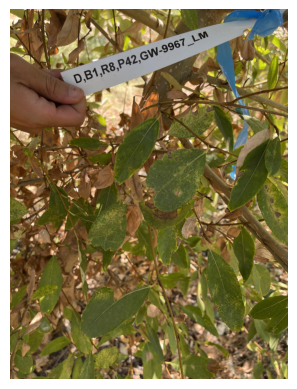

{'area_peri': 0.005837977143709578,
 'area_rect': 0.4259247246260233,
 'area_convex': 0.5979232326114556,
 'area_elli_inter': 1.1885754973291236,
 'ellipse_elli_inter': 1.6424079159985638,
 'h0': 0.5732455153966611,
 'h1': 1.809369228136784,
 'h2': 2.352954067375313,
 'h3': 3.460100494263632,
 'h4': 6.716549582762911,
 'h5': -5.191147960771708,
 'h6': 6.414973717362187}

In [4]:
def get_features(contour: cv2.Contour) -> dict[str, float]:

    # get contour moments
    moments = cv2.HuMoments(cv2.moments(contour))
    adjusted_moments = map(lambda x: -math.copysign(1.0, x) * math.log10(abs(x)), [*moments])
    moment_dict = {f'h{i}': m for i, m in enumerate(adjusted_moments)}

    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)

    # the idea here is that ratios are more important than the values themselevs
    # get ratio of area to bounding rect, perimeter, and bounding hull
    area_rect_ratio = area / (w * h)
    area_peri_ratio = area / cv2.arcLength(contour, True) ** 2    # might make it too sensitive :O
    convex_area_ratio = area / cv2.contourArea(cv2.convexHull(contour))

    # ratio of area covered by fit ellipse to contour
    el_mask, cnt_mask = [np.zeros((y+h*3, x+w*3)) for _ in range(2)]
    ellipse = cv2.fitEllipse(contour)
    ellipse_area = float(np.prod(ellipse[1])) * math.pi / 4
    el_mask = cv2.ellipse(el_mask, ellipse, 100, thickness=cv2.FILLED)
    cnt_mask = cv2.drawContours(cnt_mask, [contour], -1, 100, cv2.FILLED)
    total_mask = cv2.threshold((el_mask + cnt_mask).astype(np.uint8), 150, 255, 0)[1]
    merged_contours = cv2.findContours(total_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    total_merged_area = sum(map(cv2.contourArea, merged_contours))

    # ratio of area (in contour and ellipse) to interesct with bounding ellipse
    try:
        area_intersect_ratio = area / total_merged_area
        area_ellipse_intersect_ratio = ellipse_area / total_merged_area
    except ZeroDivisionError:
        area_intersect_ratio = area_ellipse_intersect_ratio = 100000  # big number D:

    # return extracted features
    return {
        'area_peri': area_peri_ratio,
        'area_rect': area_rect_ratio,
        'area_convex': convex_area_ratio,
        'area_elli_inter': area_intersect_ratio,
        'ellipse_elli_inter': area_ellipse_intersect_ratio
    } | moment_dict    

get_features(get_leaf_contours(get_image())[0])

#### Generate training data subjectively - see if the contours resemble actual leaves

In [ ]:
IMAGE_COUNT = 20

class FeatureThread(Thread):
    def __init__(self, contour):
        Thread.__init__(self)
        self.contour = contour
        self.features = None
    def run(self):
        self.features = get_features(self.contour)

data = []
images = [get_random_filename() for _ in range(IMAGE_COUNT)]
try:
    for filename in images:

        # get the image and the leaf contours
        img = get_image(filename, show=False)
        contours = get_leaf_contours(img)

        # go through each leaf
        for contour in contours:

            # start a thread for feature extraction
            thread = FeatureThread(contour)
            thread.start()

            # generate mask of only the leaf being shown
            mask = cv2.drawContours(np.zeros_like(img), [contour], -1, 255, cv2.FILLED)
            masked_img = cv2.bitwise_and(img, img, mask=grayscale(mask))
            imshow(masked_img)
            
            # wait for thread to run during input, join thread, and take data
            is_leaf = input("Is this image leaf-shaped?")
            thread.join()
            data.append(thread.features | {'is_leaf': is_leaf})
            clear_output()

# store data regardless of exit scenario
finally:
    df = pd.DataFrame(data)
    print(df.head())
    if "seg_from_contour" not in os.listdir():
        os.mkdir('seg_from_contour')
    df.to_csv('seg_from_contour/data.csv', index=False)

#### Train the ML model off the extracted features

In [5]:
# process the data - balance tje dataset by removing extra non-leaves
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df_leaf = df[df['is_leaf'] == 'y']
    df_no_leaf = df[df['is_leaf'] == 'n']
    n = len(df_no_leaf) - len(df_leaf)
    drop_indeces = np.random.choice(df_no_leaf.index, n, replace=False)
    return pd.concat([df_no_leaf.drop(drop_indeces), df_leaf], ignore_index=True)

# get training and testing data
df = preprocess(pd.read_csv(f"{DATA_FOLDER}/data.csv"))
y_col = [*map(lambda x: x.lower() == 'y', df.pop('is_leaf'))]
X_train, X_test, y_train, y_test = train_test_split(df, y_col, test_size=0.3)

# adjust the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# train the model and save
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)
with open(f"{DATA_FOLDER}/model.pkl", "wb") as f:
    pickle.dump(model, f)
with open(f"{DATA_FOLDER}/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):2%}")

Accuracy: 88.461538%


##### Get the confusion matrix to see results

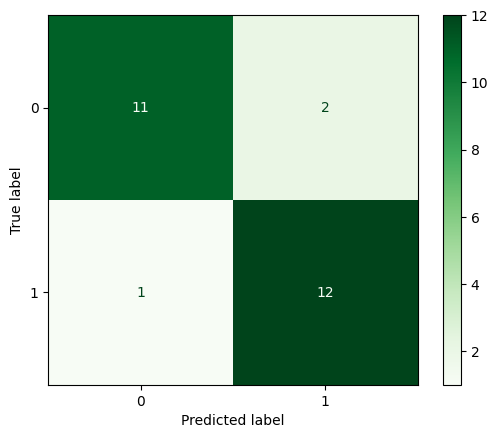

In [6]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Greens")
plt.show()

#### Load ML model to better filter leaves

FBE43022-C775-4F15-B4FC-47734A500760.jpg


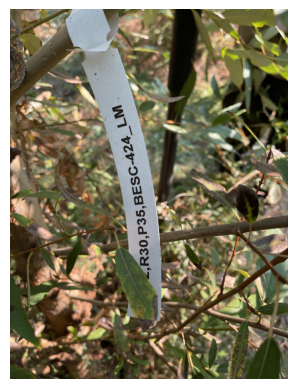

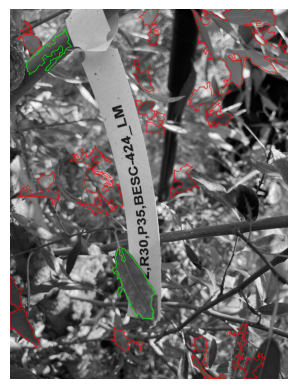

In [6]:
def load_models() -> tuple[RandomForestClassifier, StandardScaler]:
    with open(f"{DATA_FOLDER}/model.pkl", 'rb') as f:
        model = pickle.load(f)
    with open(f"{DATA_FOLDER}/scaler.pkl", 'rb') as f:
        scaler = pickle.load(f)
    return (model, scaler)

# passes contours through a filter to see the real leaves
def find_real_leaf_contours(img: cv2.Image, model: RandomForestClassifier, scaler: StandardScaler) -> list[cv2.Contour]:
    """ Filters contours through a ML model, returns the 'leaf' contours sorted by highest to lowest confidence """

    CONF_THRESHOLD = 0.70

    # get possible contours, extract features, and predict leaf or not
    contours = get_leaf_contours(img)
    features = scaler.transform(pd.DataFrame([*map(get_features, contours)]))
    predictions = model.predict_proba(features)

    # sift through contours and get the leaves that have the highest chance    
    real_contours, bad_contours = [], []
    for cntr, [_, prob_true] in zip(contours, predictions):
        if prob_true > CONF_THRESHOLD: real_contours.append([cntr, prob_true])
        else: bad_contours.append(cntr)
    sorted_real_contours = [i[0] for i in sorted(real_contours, key=lambda x: x[1], reverse=True)]
    return sorted_real_contours, bad_contours

# loads the ML models and image
model, scaler = load_models()
img = get_image()

# get the contours read and show
good_contours, bad_contours = find_real_leaf_contours(img, model, scaler)
drawn_img = draw_contours(good_contours, cv2.cvtColor(grayscale(img), cv2.COLOR_GRAY2BGR), mode="green")
drawn_img = draw_contours(bad_contours, drawn_img, mode="red")
imshow(drawn_img)

#### Crop leaves out and do more feature extraction on for next model

In [ ]:
def crop_main_leaf(img: cv2.Image, model: RandomForestClassifier, scaler: StandardScaler) -> cv2.Image:

    EXTRA_SPACE_FACTOR = 0.5

    # assure a leaf is there
    leaves = find_real_leaf_contours(img, model, scaler)[0]
    if not leaves: return None

    # calculate rectangular params
    main_leaf = leaves[random.choice([*range(len(leaves))])]
    x, y, w, h = cv2.boundingRect(main_leaf)

    # calculate adjusted dimensions and angle
    y_min = max(int(y-h*EXTRA_SPACE_FACTOR), 0)
    x_min = max(int(x-w*EXTRA_SPACE_FACTOR), 0)
    y_max = min(int(y+h*(1+EXTRA_SPACE_FACTOR)), len(img))
    x_max = min(int(x+w*(1+EXTRA_SPACE_FACTOR)), len(img[0]))

    # focus on only the area of the leaf in the image
    cropped_img = img[y_min:y_max, x_min:x_max]
    return cropped_img
    
# load model and image
model, scaler = load_models()
img = get_image()

leaf_focus = crop_main_leaf(img, model, scaler)
if leaf_focus is not None: imshow(leaf_focus)